# All imports

In [1]:
import os
from google_drive_downloader import GoogleDriveDownloader as gdd

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
%matplotlib inline
sns.set_style('darkgrid')

# Load data

In [3]:
if not os.path.exists('./data'):
  os.mkdir('./data')

gdd.download_file_from_google_drive(file_id='1r6U_EFULKXiuLPrIEAdoJ7W_1Xa7aJ3Q', dest_path='./data/movies.zip')

In [4]:
! unzip ./data/movies.zip -d ./data/unziped

Archive:  ./data/movies.zip
  inflating: ./data/unziped/links.csv  
  inflating: ./data/unziped/movies.csv  
  inflating: ./data/unziped/ratings.csv  
  inflating: ./data/unziped/tags.csv  
  inflating: ./data/unziped/u.data   


# EDA

In [0]:
ratings_df = pd.read_csv('/content/data/unziped/ratings.csv')

In [6]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [0]:
ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], unit='s')

In [8]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,2009-12-14 02:52:24
1,1,1029,3.0,2009-12-14 02:52:59
2,1,1061,3.0,2009-12-14 02:53:02
3,1,1129,2.0,2009-12-14 02:53:05
4,1,1172,4.0,2009-12-14 02:53:25


Check nans

In [9]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     100004 non-null  int64         
 1   movieId    100004 non-null  int64         
 2   rating     100004 non-null  float64       
 3   timestamp  100004 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 3.1 MB


In [10]:
ratings_df['userId'].nunique()

671

In [11]:
ratings_df['movieId'].nunique()

9066

Sparcity

In [12]:
ratings_df.shape[0] / (ratings_df['userId'].nunique() * ratings_df['movieId'].nunique())

0.016439141608663475

Ratings distribution over users

Text(0.5, 0, 'number of ratings per user')

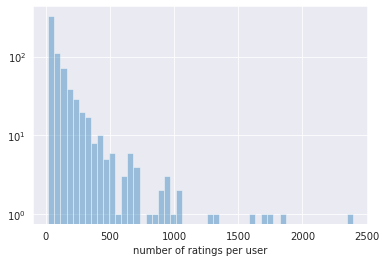

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
sns.distplot(ratings_df.groupby('userId').agg({'rating':'count'}),ax=ax,kde=False)
ax.set_yscale('log')
ax.set_xlabel("number of ratings per user")

Ratings distribution over movies

Text(0.5, 0, 'number of ratings per movie')

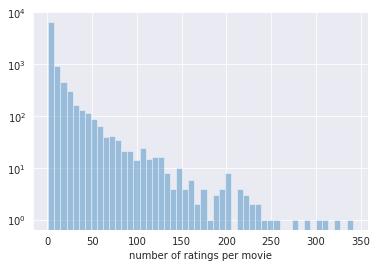

In [14]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
sns.distplot(ratings_df.groupby('movieId').agg({'rating':'count'}),ax=ax,kde=False)
ax.set_yscale('log')
ax.set_xlabel("number of ratings per movie")

# Dataset preprocessing

Let's transform it from explicit to implicit due to following rule:

1 if we have rating for pair (user, movie), 0 otherwise

In [0]:
ratings_df['rating'] = 1

In [0]:
ratings_per_user = ratings_df.groupby('userId').agg({'rating':'count'}).reset_index().rename(columns={'rating':'rating_num'})

There is no need in removing any users, there are no cold users.

In [17]:
ratings_per_user['rating_num'].min()

20

In [0]:
ratings_per_movie = ratings_df.groupby('movieId').agg({'rating':'count'}).reset_index().rename(columns={'rating':'rating_num'})

In [19]:
ratings_per_movie['rating_num'].min()

1

In [0]:
ratings_df.rename(columns={'movieId':'itemId'}, inplace=True)

## TODO: Decide whether there is need in removing cold items.

# Most popular recommender

In [0]:
class MostPopularRecommender():
  def __init__(self):
    self.sorted_items = None

  def fit(self, X):
    """Build list of items according to their popularity

    :param X: incoming data for fitting contains 'userId' and 'itemId' columns (DataFrame)
    """
    self.sorted_items = X.groupby('itemId').agg({'rating':'count'}).sort_values(by='rating', ascending=False).reset_index()['itemId'].tolist()
  
  def predict(self, X, top_n):
    """Predict top_n popular items for each user
    
    :param X: incoming data for prediction contains 'userId' column (DataFrame)
    :param top_n: number of recommendations (int)
    :return: items recommendations for each user (DataFrame)
    """
    prediction_df = pd.DataFrame()
    prediction_df['userId'] = X['userId'].unique()
    prediction_df['rec_items'] = [self.sorted_items[:top_n] for _ in range(X['userId'].nunique())]
    return prediction_df

In [0]:
mp = MostPopularRecommender()

In [0]:
mp.fit(ratings_df)

In [0]:
predicted_df = mp.predict(ratings_df,3)

# Metrics

In [0]:
def collect_ground_truth(X):
  """Build list of ground truth for every user based on X provided data"""
  
  return X.groupby('userId').agg({'itemId':list}).reset_index().rename(columns={'itemId':'ground_truth_items'})

In [0]:
ground_truth_df = collect_ground_truth(ratings_df)

##TODO: Discuss implementation

In [0]:
def precision_at_k(predicted, ground_truth, k):
  assert len(predicted) >= k
  intersection = set(predicted[:k]) & set(ground_truth)
  return len(intersection) / k
  #return len(intersection) / min(k,len(ground_truth))

In [0]:
def recall_at_k(predicted, ground_truth, k):
  assert len(predicted) >= k
  intersection = set(predicted[:k]) & set(ground_truth)
  return len(intersection) / len(ground_truth)
  #return len(intersection) / min(k,len(ground_truth))

In [0]:
def hit_rate_at_k(predicted, ground_truth, k):
  assert len(predicted) == k
  intersection = set(predicted[:k]) & set(ground_truth)
  return 1 if len(intersection) > 0 else 0

In [0]:
def ndcg_at_k(predicted, ground_truth, k):
  assert len(predicted) >= k
  gain = sum([1/np.log2(i+2) for i, item in enumerate(predicted[:k]) if item in ground_truth])
  max_gain = sum([1/np.log2(i+2) for i in range(len(ground_truth))])
  return gain / max_gain


In [0]:
def average_precision_at_k(predicted, ground_truth, k):
  pass

In [0]:
def mean_metric(predicted_df, ground_truth_df, metric_func, k):
  merged_df = pd.merge(ground_truth_df, predicted_df, on='userId')
  return np.mean([metric_func(row['rec_items'], row['ground_truth_items'], k=k) for _, row in  merged_df.iterrows()])

In [76]:
mean_metric(predicted_df, ground_truth_df, hit_rate_at_k, k=3)

0.7168405365126677

In [77]:
mean_metric(predicted_df, ground_truth_df, precision_at_k, k=3)

0.4848484848484848

In [78]:
mean_metric(predicted_df, ground_truth_df, recall_at_k, k=3)

0.01875780010225043

In [92]:
mean_metric(predicted_df, ground_truth_df, ndcg_at_k, k=3)

0.05321607312475447

In [0]:
predicted = [1,3,2]
actual = [2,5,7]

In [94]:
precision_at_k(predicted,actual,k=3)

0.3333333333333333

In [95]:
hit_rate(predicted,actual,k=1)

0

In [96]:
ndcg(predicted, actual,k=3)

0.23463936301137822